In [1]:
#The analysis from this notebook has been done from this data
#132.166.26.39:/data/pipeline/CFIS_process/results/final_cat.fits

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import cm
from scipy import fftpack

# Functions to build maps 

In [3]:
def correct_ra(ra, dec):
	"""
	It redefines RA according to a sinusoidal projection of the sky, 
	so that all pixels have the same area (https://en.wikipedia.org/wiki/Sinusoidal_projection)
	"""
	return (ra - np.mean(ra))*np.cos(dec/180.*np.pi)

def make_maps(map, w, dec, ra, ndec, nra):
	 """
	 Make tagged maps, weighted by SNR
	 """
 
	 map_2d, edges = np.histogramdd(np.array([dec, ra]).T, bins=(ndec, nra), weights=map*w)
	 w_2d, edges = np.histogramdd(np.array([dec, ra]).T, bins=(ndec, nra), weights=w)
	 w_2d[w_2d==0]=np.nan
	 return map_2d/w_2d
    


### function to convert from gamma to kappa

In [4]:
def g2k_fft(g1, g2, dx):
	"""
	Convert gamma to kappa in Fourier space 
	(Sect. 2.2 from Chang et al. 2016, MNRAS, 459, 3203)
	"""

	g1_3d_ft = fftpack.fft2(g1)
	g2_3d_ft = fftpack.fft2(g2)
	FF1 = fftpack.fftfreq(len(g1_3d_ft))
	FF2 = fftpack.fftfreq(len(g1_3d_ft[0]))

	dk = 1.0/dx*2*np.pi                	    # max delta_k in 1/arcmin
	kx = np.dstack(np.meshgrid(FF2, FF1))[:,:,0]*dk
	ky = np.dstack(np.meshgrid(FF2, FF1))[:,:,1]*dk
	kx2 = kx**2
	ky2 = ky**2
	k2 = kx2 + ky2

	# kappa to everything
	k2[k2==0] = 1e-15
	#k2psi_ft = kE_3d_ft/k2*2      # arcmin^2
	#k2alphax_ft = k2psi_ft*kx        # arcmin
	#k2alphay_ft = k2psi_ft*ky
	g2kappaE_ft = g1_3d_ft/k2*(kx2-ky2) + g2_3d_ft/k2*2*(kx*ky)
	g2kappaB_ft = -1*g1_3d_ft/k2*2*(kx*ky) + g2_3d_ft/k2*(kx2-ky2)

	return fftpack.ifft2(g2kappaE_ft).real, fftpack.ifft2(g2kappaB_ft).real

### functions for cross correlations and its errors

get_cross_corr calculates the following cross correlation of two grids A and B:

$\langle A B\rangle / \sqrt{ \langle A^2\rangle \langle B^2 \rangle}$.

cross_corr repeats get_cross_corr for different JK subsamples (made with make_jk_randmap) and obtains the error using the function jack_knife, giving an error of:

$\sigma = \frac{n_{jk} - 1}{n_{jk}} \sqrt{\sum_{i=1}^{n_{jk}} (x_i - \bar x)^2}$,

where $n_{jk}$ is the number of subsamples, $x_i$ the measurement in the $i$th subsample and $\bar x$ the average measurement. 

In [5]:
def cross_corr(grid1, grid2, jk_dim, jk_map = None, verbose = False):
    """It calculates the zero-lag correlation function of two 2d
       grids (or 1d maps) and its jack-knife error. grid1 and grid2 must have the same shape.
       If jk_map is not None, it is considered as the indexes of the JK samples of the maps."""
    if verbose:
        print "Calculating zero-lag correlation with JK error"
    #calculate grid to define JK subsamples
    if jk_map is None:
        jk_grid = make_jk_randmap(grid1, jk_dim)#Grid of indeces according to the JK they belong to
        total_jk = jk_dim**2
    else:
        jk_grid = jk_map
        total_jk = jk_dim
    #calculate zero-lag of all the grid
    corr = get_cross_corr(grid1,grid2)
    #calculate zero-lags in subgrids
    sub_corr = []
    for i in range(total_jk):
        sub_grid1 = grid1[jk_grid != i]
        sub_grid2 = grid2[jk_grid != i]
        sub_corr.append(get_cross_corr(sub_grid1, sub_grid2))
    corr_err = jack_knife(corr, sub_corr)
    return corr, corr_err

def get_cross_corr(grid1, grid2):
    """
    It calculated the cross correlation between both maps.
    """
    return np.mean(grid1*grid2)/np.sqrt(np.mean(grid1**2.)*np.mean(grid2**2.))

def jack_knife(var, jk_var):
	"""
		It gives the Jack-Knife error of var from the jk_var subsamples.
		Inputs: 
		var: the mean value of the variable. Constant number.
		jk_var: the variable from the subsamples. The shape of the jk_var must be (jk subsamples, bins)

	 	Output: 
		jk_err: the JK error of var. 
		"""
	if type(var) == np.ndarray:
		jk_dim = jk_var.shape[0]
		err = (jk_dim - 1.)/jk_dim * (jk_var - var)**2.
		jk_err = np.sqrt(np.sum(err, axis = 0))
	else:
		jk_dim = len(jk_var)
		err = (jk_dim - 1.)/jk_dim * (jk_var - var)**2.
		jk_err = np.sqrt(np.sum(err))
	return jk_err

def make_jk_randmap(grid, jk_dim):
	"""It generates a map with different indeces for each of the jk subsamples.
	   """
	grid_dim1 = grid.shape[0]
	ratio1 = grid_dim1/jk_dim + int(grid_dim1%jk_dim > 0)
	jk_grid = np.arange(grid_dim1, dtype = int)/ratio1
	return jk_grid

In [6]:
def get_bin_edges(array, nbins, equal_bins = True):
    """From an array, it defines the bin edges
    which define the number of bins nbins.
    Input:
    array: array of values.
    nbins: number of bins.
    equal_bins: if True, each bin has the same
       number of elements. Otherwise, the bin separation
       is linear
    Output:
    bin_edges: array of nbins+1 elements.
    """    
    if equal_bins:
        lims = np.linspace(0,len(array[(array < np.inf)]) - 1, nbins + 1)
        lims = np.array(lims, dtype = int)
        bin_edges = np.sort(array[(array < np.inf)])[lims]
        return np.unique(bin_edges)
    else:
        return np.linspace(min(array), max(array), nbins + 1)

def plot_mean_per_bin(xvar, xname, yvar, yname, nbins, filter_arr, c  = 'k', show = True, marker = 's', ylims = None, leg_loc = 'upper center', equal_bins = True, linestyle = '-', lw = 3, leg_ncol = 1):
    """
   It plots the mean value of a variable as a function of another one.
   Input:
   xvar: array, variable that is binned in the x axis.
   xname: string, name of the variable that appears in x label.
   yvar: array, variable which mean is calculated in each x bin.
   yname: string, name of the variable, shown in the legend.
   nbins: integer, specifies the number of x bins used.
   filter_array: boolean array which defines a selection of the objects in 
    xvar and yvar.
   c: colour of the error bars and points used.
   show: if True, it shows the plot.
   marker: marker of plotted points.
   ylims: None or [a,b], defining (if not None0 the y axes limits.
   leg_loc: position of legend.
   equal_bins: if True, each bin has the same number of elements. Otherwise,
       bins are defined linearly according to the min and max values.
   linestyle: string, linestyle of the plot.
   lw: float, line width of the plot.
   leg_ncol: integer, number of columns in the legend.
   Output:
   It generates a plot that can be saved and/or shown if specified.
   x_plot: mean x for each bin.
   y_plot, err_plot: mean y for each bin and its error.
   """
    xvar_f = xvar[filter_arr]
    yvar_f = yvar[filter_arr]
    bin_edges = get_bin_edges(xvar_f, nbins, equal_bins = equal_bins)
    random_amplitude = (bin_edges[1] - bin_edges[0])/20.
    x_plot = []
    y_plot = []
    err_plot = []
    for i in range(nbins):
        filter_bin = (xvar_f > bin_edges[i])*(xvar_f < bin_edges[i+1])
        mean = np.mean(yvar_f[filter_bin])
        err = np.std(yvar_f[filter_bin])
        rand =  np.random.random()*random_amplitude
        x_plot.append(np.mean(xvar_f[filter_bin]) + rand)
        y_plot.append(mean)
        err_plot.append(err/np.sqrt(np.sum(filter_bin)))
    plt.errorbar(x_plot, y_plot, err_plot, c = c, marker = marker, markersize = 5, label = yname, linestyle = linestyle, lw = lw)
    if ylims is not None:
        plt.ylim(ylims[0], ylims[1])
    plt.xlabel(xname)
    if show:
        plt.legend(loc = leg_loc, frameon = False, fontsize = 10, ncol = leg_ncol)
        plt.show()

### Parameters to be defined 

In [7]:
params = {
'nside' : 2048, #healpy resolution
'smooth' : 10., #smoothing scale to apply (if asked) to the maps
'jk' : 20, #number of Jack-Knife realizations
'pix' : 1., #angular pixel scale in arcmin
}




# Read data 

In [8]:
a = fits.open('/Users/apujol/Documents/physics/codes/test/CFIS/final_cat.fits', ignore_missing_end=True)
data = a[1].data
print a[1].columns
a.close()

ColDefs(
    name = 'g1_median'; format = '1D'
    name = 'm1_2'; format = '1D'
    name = 'm1_1'; format = '1D'
    name = 'g2_median_cfhtlens'; format = '1D'
    name = 'e2_diff_median_abs'; format = '1D'
    name = 'mag'; format = '1D'
    name = 'p1_1'; format = '1D'
    name = 'g1_object'; format = '1D'
    name = 'n_field'; format = '1D'
    name = 'p1_2'; format = '1D'
    name = 'flux_radius'; format = '1D'
    name = 'g2_mean_field'; format = '1D'
    name = 'g1_mean'; format = '1D'
    name = 'g1_mean_field'; format = '1D'
    name = 'p2_2'; format = '1D'
    name = 'p2_1'; format = '1D'
    name = 'e2_diff_median'; format = '1D'
    name = 'R11'; format = '1D'
    name = 'ns_1'; format = '1D'
    name = 'ns_2'; format = '1D'
    name = 'n_star'; format = '1D'
    name = 'm2_1'; format = '1D'
    name = 'm2_2'; format = '1D'
    name = 'e2_diff_mean'; format = '1D'
    name = 'ra'; format = '1D'
    name = 'dist_cfis_cfhtlens'; format = '1D'
    name = 'g1_median_cfhtlens'; f

    Header size is not multiple of 2880: 109758960
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


These are all the CFIS ellipticity estimations from the data: 
- gi_median is the calibrated ellipticity from the median responses r11 and r22
- gi_mean is the same but from the mean responses. 
- ns_i is the original ellipticity_i
- gi_mean_field is the calibrated ellipticity from the mean responses of each field
- gi_median_field is the calibrated ellipticity from the median responses of each field
- gi_object is the calibrated data from their individual responses

In [9]:
ra_proj = correct_ra(data['ra'], data['dec'])#Projected RA
params['ra_max'] = np.max(ra_proj)
params['ra_min'] = np.min(ra_proj)
params['dec_max'] = np.max(data['dec'])
params['dec_min'] = np.min(data['dec'])
numbins_ra = max(1, round((params['ra_max'] - params['ra_min'])*60./params['pix'], 0))#number of bins in ra_l. 
numbins_dec = max(1, round((params['dec_max'] - params['dec_min'])*60./params['pix'], 0))#number of bins in dec_l. 



### Some histograms 

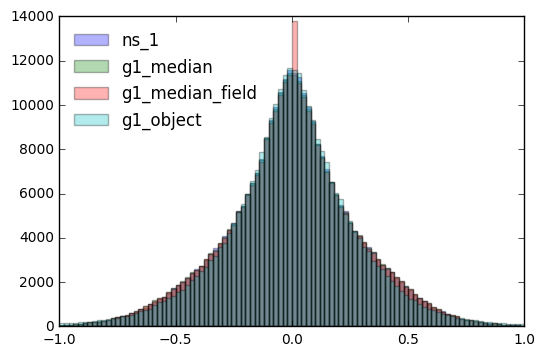

In [10]:
plt.hist(data['ns_1'],100, range = [-1,1], alpha = .3, label = 'ns_1')
plt.hist(data['g1_median'],100, range = [-1,1], alpha = .3, label = 'g1_median')
plt.hist(data['g1_median_field'],100, range = [-1,1], alpha = .3, label = 'g1_median_field')
plt.hist(data['g1_object'],100, range = [-1,1], alpha = .3, label = 'g1_object')
plt.legend(frameon = False, loc = 2)
plt.show()



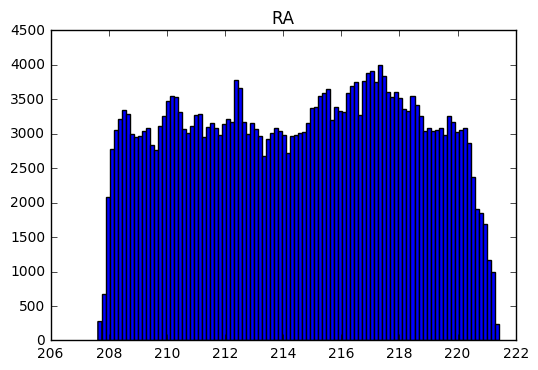

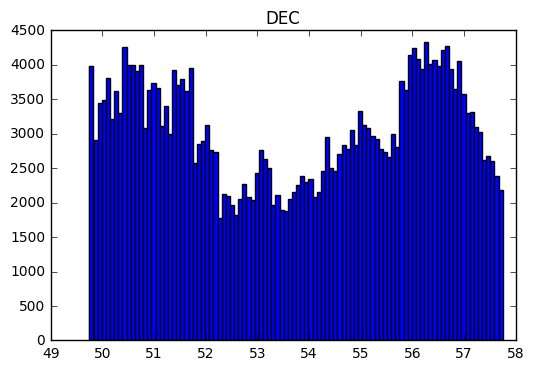

In [11]:
plt.hist(data['ra'],100)
plt.title('RA')
plt.show()
plt.hist(data['dec'],100)
plt.title('DEC')
plt.show()

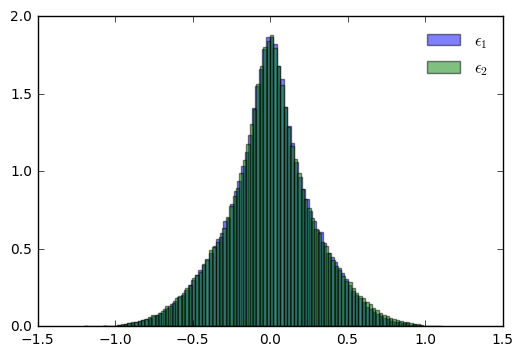

In [12]:
plt.hist(data['g1_mean'], 100, normed=True, alpha = .5, label = r'$\epsilon_1$')
plt.hist(data['g2_mean'], 100, normed=True, alpha = .5, label = r'$\epsilon_2$')
plt.legend(frameon = False)
plt.show()

# Correlations between individual objects 

In [13]:
#list of properties of the objects to be studied
list_props = ['g1_median', 'mag', 'g1_object', 'flux_radius', 'g2_mean_field',\
 'g1_mean_field', 'R11', 'ns_1', 'ns_2', 'n_star', 'ra', 'PSF_e2', 'PSF_e1',\
 'PSF_fwhm', 'g2_median_field', 'g2_object', 'elongation', 'flux', 'dec', 'R22']

### In the following, we plot the correlations between two properties A and B by plotting the average A as a function of the value of B. A is normalized so that it is between 0 and 1.

This defines the legend of the properties

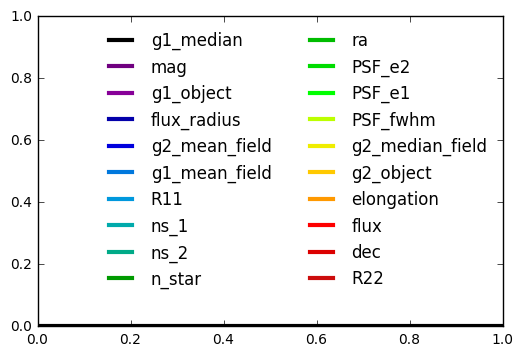

In [14]:
mask_array = (np.abs(data['g1_object'])<1)*(np.abs(data['g2_object'])<1)*(data['mag']<27)*(data['elongation']<5)
color_list = [cm.nipy_spectral(float(nn)/len(list_props)) for nn in range(len(list_props))]
#Printing legend
for nn, jj in enumerate(list_props):
    plt.plot([0,1], [-nn, -nn], c = color_list[nn], label = list_props[nn], lw = 3)
plt.legend(frameon = False, ncol = 2)
plt.ylim(0,1)
plt.show()

Here we show the correlations. Here we split each property in bins. The bins can be linear with the range of values (if equal_bins == False) or equally dense (if equal_bins == True). In each bin in the x variable, we show the mean normalized y $\langle \bar{y} \rangle$, where $\bar y = (y - \min y)/(\max y - \min y)$

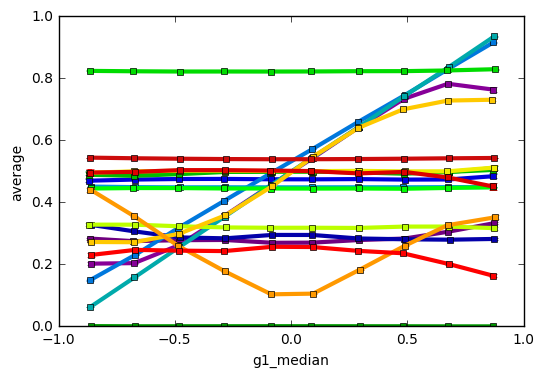

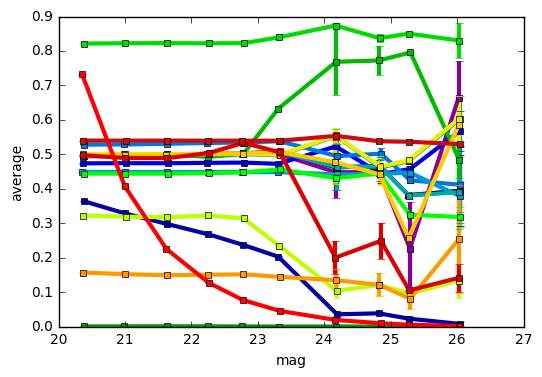

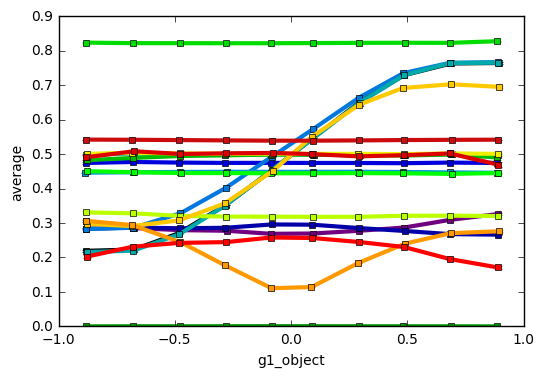

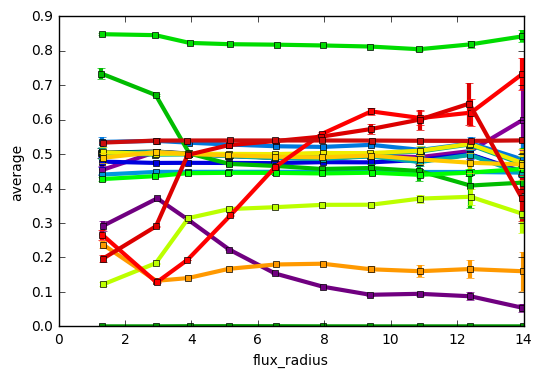

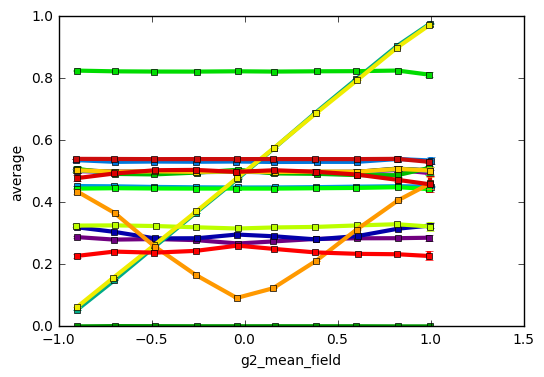

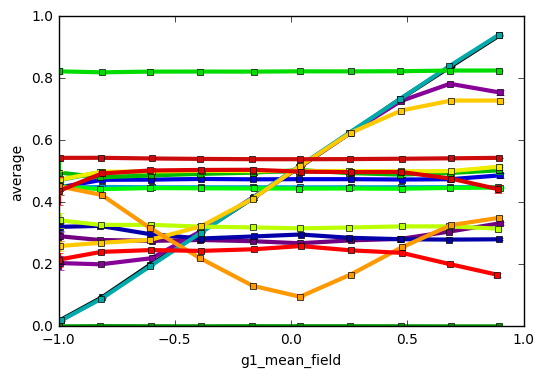

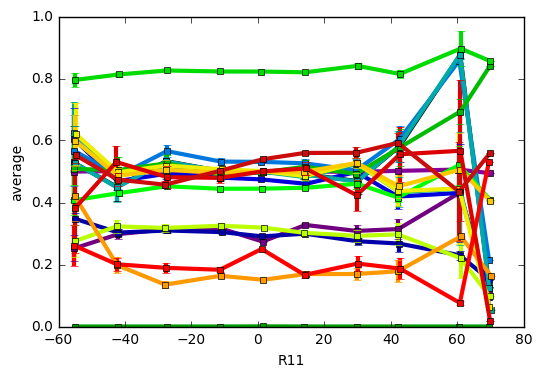

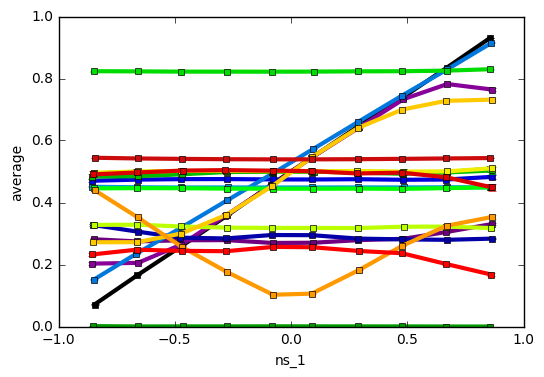

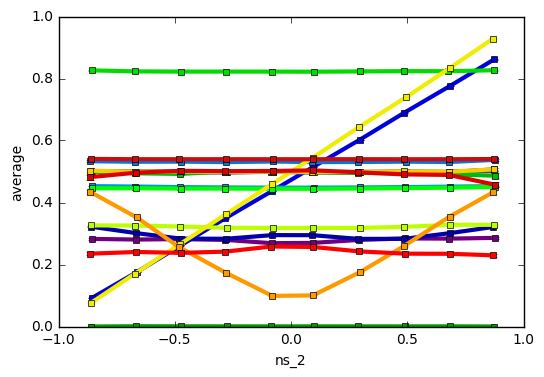

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:

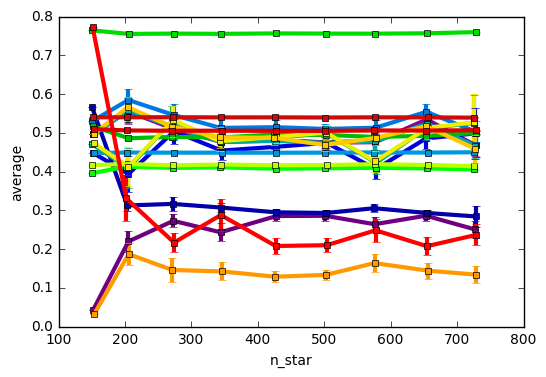

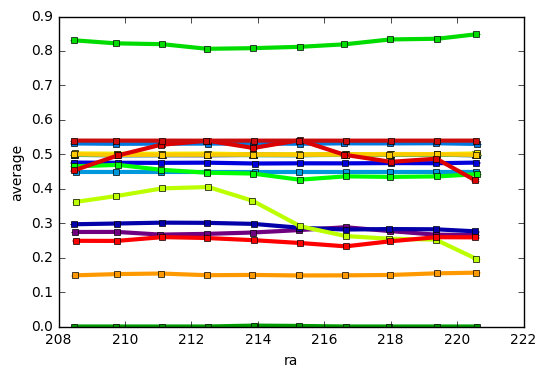

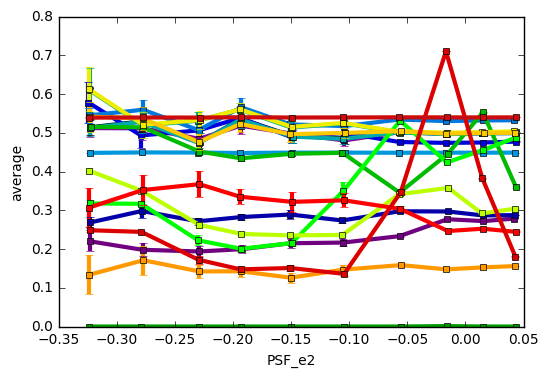

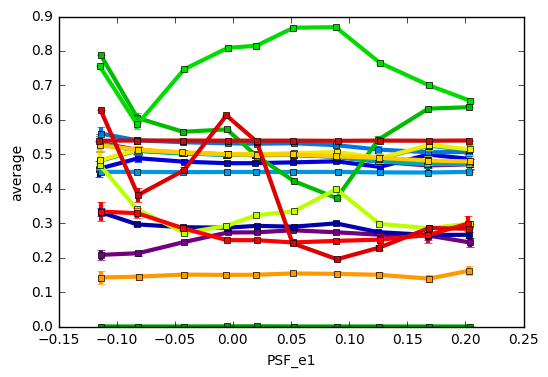

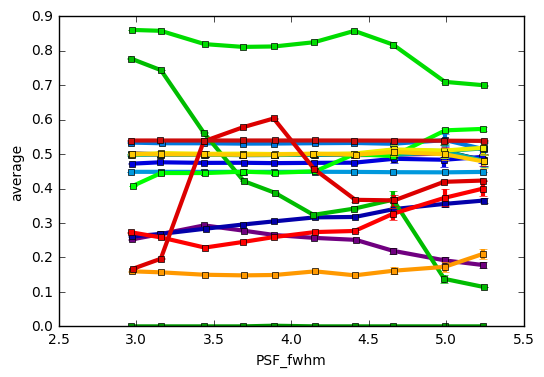

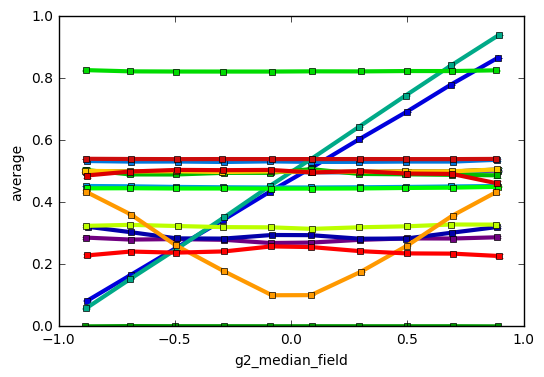

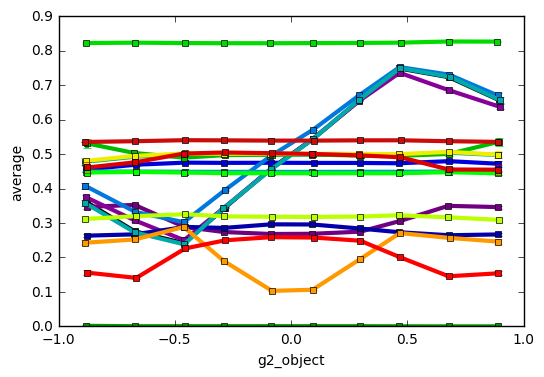

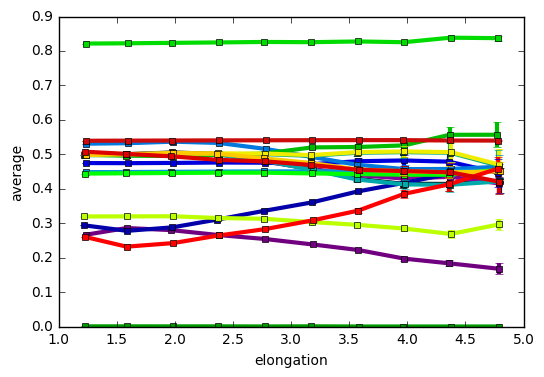

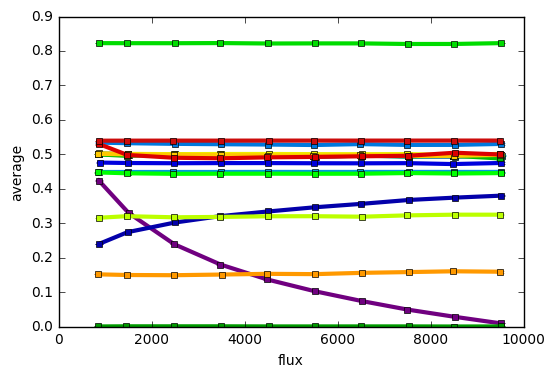

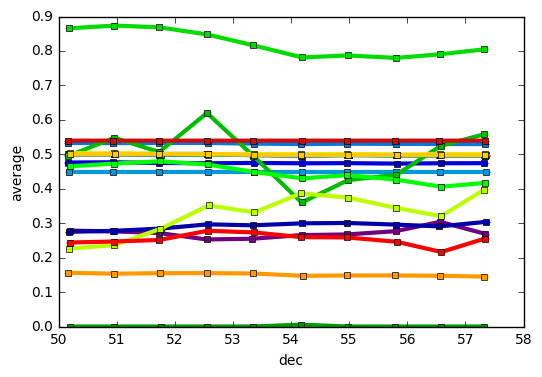

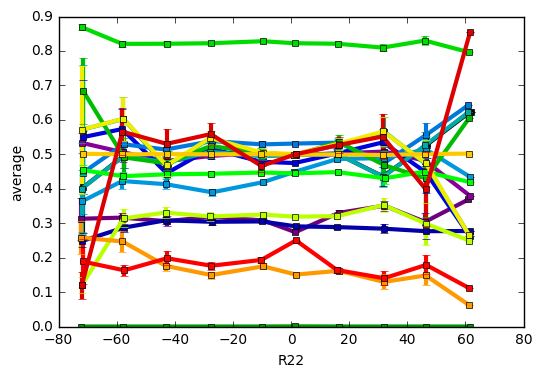

In [15]:
for ii in list_props:
    xname = ii
    for nn, jj in enumerate(list_props):
        yname = jj
        if ii != jj:
            norm_y = (data[yname] - np.min(data[yname][mask_array]))/(np.max(data[yname][mask_array]) - np.min(data[yname][mask_array]))
            plot_mean_per_bin(data[xname], xname, norm_y, yname, 10, mask_array, c  = color_list[nn], show = False, marker = 's', ylims = None, leg_loc = 'upper center', equal_bins = False, linestyle = '-', lw = 3, leg_ncol = 1)
    #we can show here the legends if it's clearer
    #plt.legend(frameon = False)
    plt.ylabel('average')
    plt.show()

#  make and plot number counts

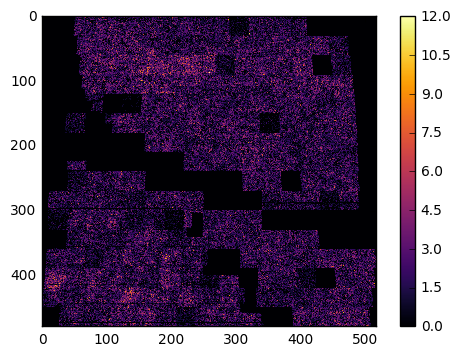

In [16]:
num_counts, edges = map_2d, edges = np.histogramdd(np.array([data['dec'], ra_proj]).T, bins=(numbins_dec, numbins_ra))
plt.imshow(num_counts[::-1,::-1], interpolation='none', cmap = 'inferno')
plt.colorbar()

The following histogram shows the distances between CFIS and CFHT galaxies. We can see that many galaxies have a very small distance, meaning they are the same galaxies. Then, we have an intermediate scale where we don't find galaxies with this separation. This can be an exclusion effect due to impossibility of finding different galaxies that close. Then we have again galaxies with larger distances, meaning they are different object. From this plot, I will define the galaxies matched with CHFT as the ones in the first bin

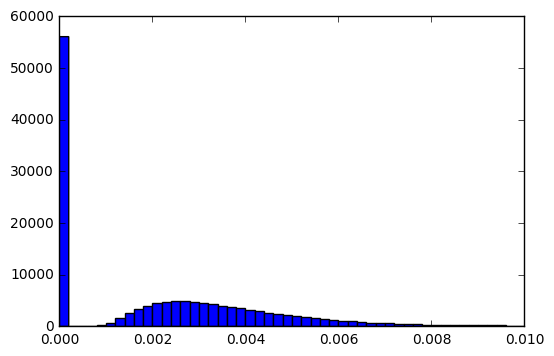

In [17]:
plt.hist(data['dist_cfis_cfhtlens'],50, range=[0,.01])
plt.show()

In [18]:
cfht_matched = data['dist_cfis_cfhtlens']<.001

number of galaxies vs number of galaxies matched with CFHT is: 

### Number counts of galaxies matched with CFHT 

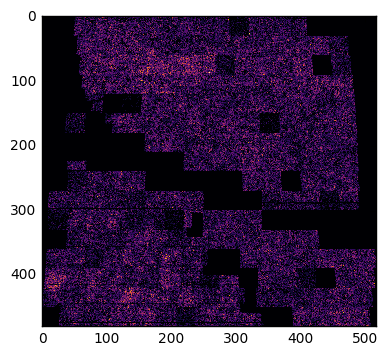

In [19]:
num_counts_cfht, edges = map_2d, edges = np.histogramdd(np.array([data['dec'][cfht_matched], ra_proj[cfht_matched]]).T, bins=(numbins_dec, numbins_ra))
plt.imshow(num_counts[::-1,::-1], interpolation='none', cmap = 'inferno')

### Overlapp between matched and unmatched galaxies 

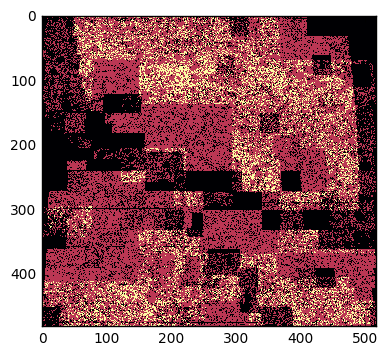

In [20]:
overlap = np.array((num_counts> 0), dtype=int) + np.array(num_counts_cfht>0, dtype=int)
plt.imshow(overlap[::-1,::-1], interpolation='none', cmap = 'inferno')

### make and show mask 

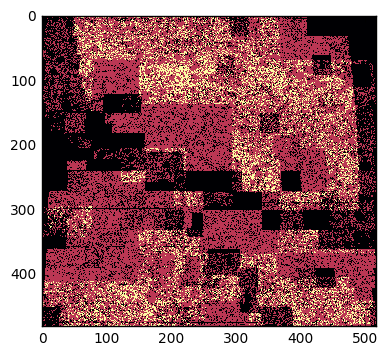

In [21]:
mask = num_counts > 0
plt.imshow(overlap[::-1,::-1], interpolation='none', cmap = 'inferno')

# make and plot shear and kappa maps 

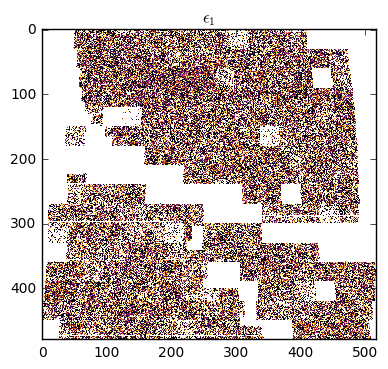

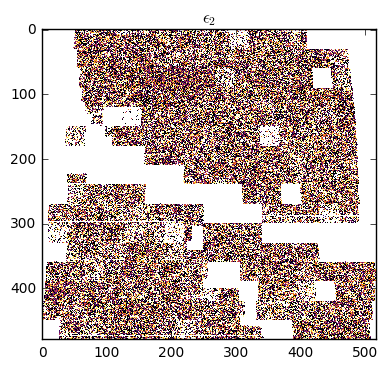

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less


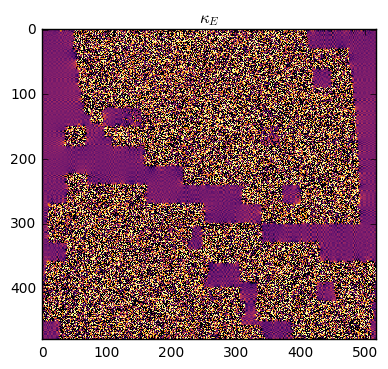

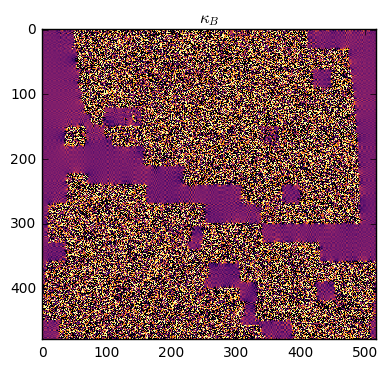

In [22]:
w = data['g1_median']*0. + 1.
ellip1 = make_maps(data['g1_median'], w, data['dec'], ra_proj, numbins_dec, numbins_ra)
ellip2 = make_maps(data['g2_median'], w, data['dec'], ra_proj, numbins_dec, numbins_ra)
plt.imshow(ellip1[::-1,::-1], interpolation='none', cmap = 'inferno', vmin = -.1, vmax = .2)
plt.title(r'$\epsilon_1$')
plt.show()
plt.imshow(ellip2[::-1,::-1], interpolation='none', cmap = 'inferno', vmin = -.1, vmax = .2)
plt.title(r'$\epsilon_2$')
plt.show()

ellip1[(ellip1 < np.inf)==False] = 0.
ellip2[(ellip2 < np.inf)==False] = 0.
kappa_E, kappa_B = g2k_fft(ellip1, ellip2, 1)

plt.imshow(kappa_E[::-1,::-1], interpolation='none', cmap = 'inferno', vmin = -.1, vmax = .2)
plt.title(r'$\kappa_E$')
plt.show()
plt.imshow(kappa_B[::-1,::-1], interpolation='none', cmap = 'inferno', vmin = -.1, vmax = .2)
plt.title(r'$\kappa_B$')
plt.show()



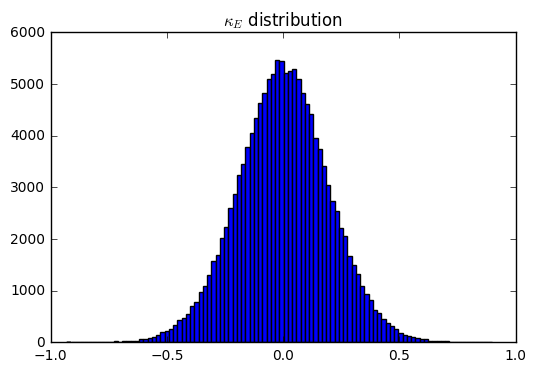

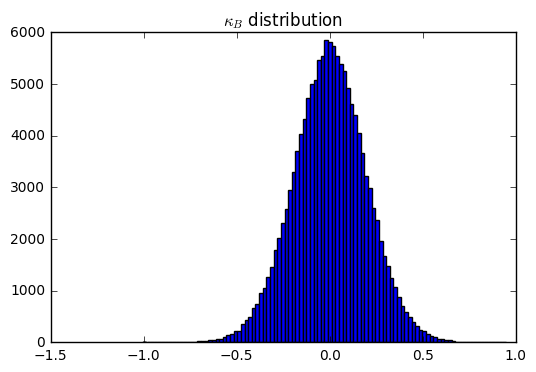

In [23]:
plt.hist(kappa_E[mask],100)
plt.title(r'$\kappa_E$ distribution')
plt.show()
plt.hist(kappa_B[mask],100)
plt.title(r'$\kappa_B$ distribution')
plt.show()

# Other maps 

In [24]:
stars_in_field = np.array([data['n_star'][i] for i in data['n_field']])
    

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


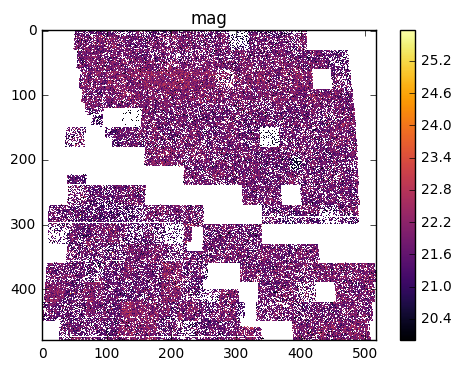

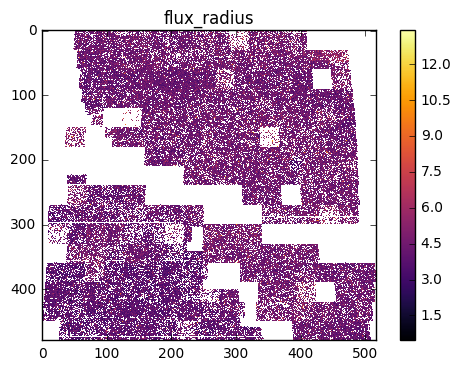

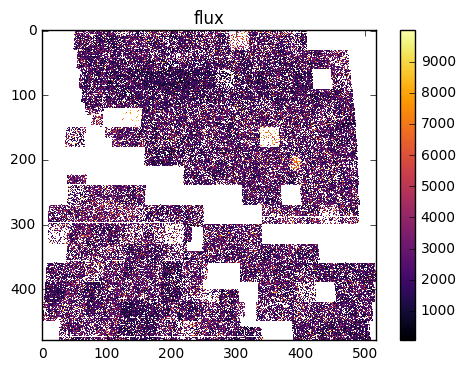

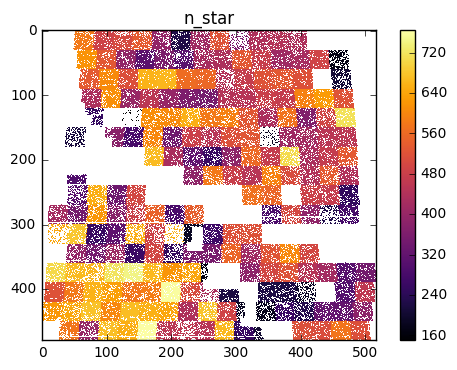

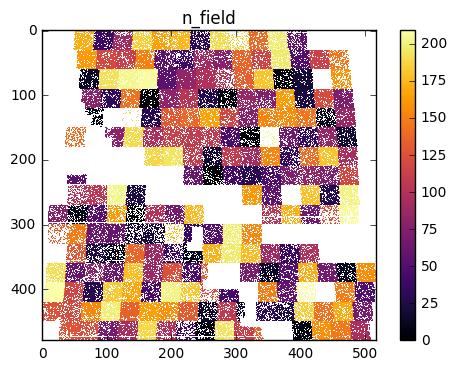

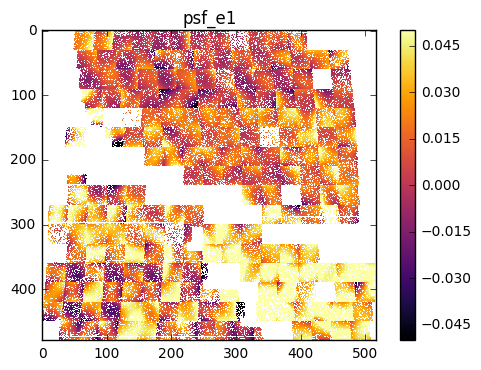

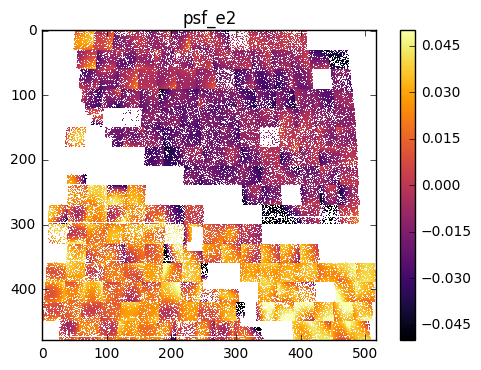

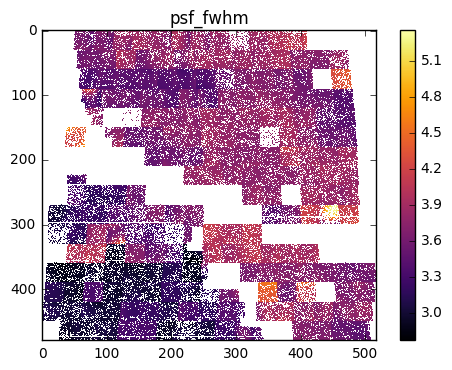

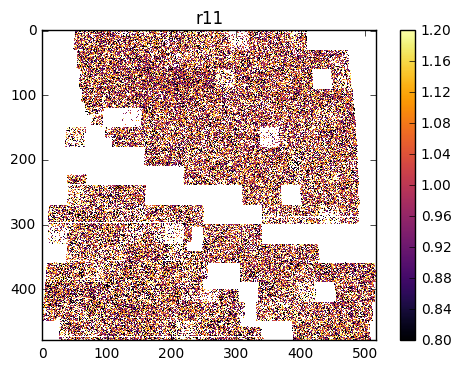

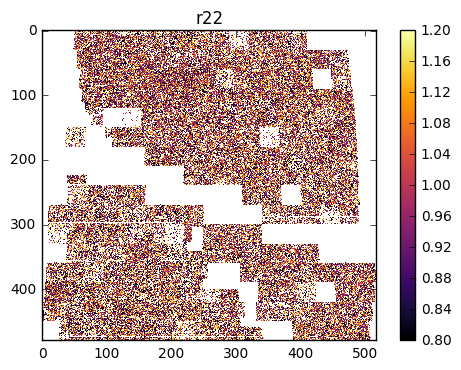

In [25]:
filt = data['mag'] < 30
mag = make_maps(data['mag'][filt], w[filt], data['dec'][filt], ra_proj[filt], numbins_dec, numbins_ra)
plt.imshow(mag[::-1,::-1], interpolation='none', cmap = 'inferno')
plt.title(r'mag')
plt.colorbar()
plt.show()

filt = data['flux_radius'] > 0
flux_radius = make_maps(data['flux_radius'][filt], w[filt], data['dec'][filt], ra_proj[filt], numbins_dec, numbins_ra)
plt.imshow(flux_radius[::-1,::-1], interpolation='none', cmap = 'inferno')
plt.title(r'flux_radius')
plt.colorbar()
plt.show()

filt = data['flux'] > 0
flux = make_maps(data['flux'][filt], w[filt], data['dec'][filt], ra_proj[filt], numbins_dec, numbins_ra)
plt.imshow(flux[::-1,::-1], interpolation='none', cmap = 'inferno')
plt.title(r'flux')
plt.colorbar()
plt.show()


n_star = make_maps(stars_in_field, w, data['dec'], ra_proj, numbins_dec, numbins_ra)
plt.imshow(n_star[::-1,::-1], interpolation='none', cmap = 'inferno')
plt.title(r'n_star')
plt.colorbar()
plt.show()

n_field = make_maps(data['n_field'], w, data['dec'], ra_proj, numbins_dec, numbins_ra)
plt.imshow(n_field[::-1,::-1], interpolation='none', cmap = 'inferno')
plt.title(r'n_field')
plt.colorbar()
plt.show()

psf_e1 = make_maps(data['psf_e1'], w, data['dec'], ra_proj, numbins_dec, numbins_ra)
plt.imshow(psf_e1[::-1,::-1], interpolation='none', cmap = 'inferno', vmin = -.05, vmax = .05)
plt.title(r'psf_e1')
plt.colorbar()
plt.show()

psf_e2 = make_maps(data['psf_e2'], w, data['dec'], ra_proj, numbins_dec, numbins_ra)
plt.imshow(psf_e2[::-1,::-1], interpolation='none', cmap = 'inferno', vmin = -.05, vmax = .05)
plt.title(r'psf_e2')
plt.colorbar()
plt.show()

psf_fwhm = make_maps(data['psf_fwhm'], w, data['dec'], ra_proj, numbins_dec, numbins_ra)
plt.imshow(psf_fwhm[::-1,::-1], interpolation='none', cmap = 'inferno')
plt.title(r'psf_fwhm')
plt.colorbar()
plt.show()

r11_map = make_maps(data['r11'], w, data['dec'], ra_proj, numbins_dec, numbins_ra)
plt.imshow(r11_map[::-1,::-1], interpolation='none', cmap = 'inferno', vmin = .8, vmax = 1.2)
plt.title(r'r11')
plt.colorbar()
plt.show()

r22_map = make_maps(data['r22'], w, data['dec'], ra_proj, numbins_dec, numbins_ra)
plt.imshow(r22_map[::-1,::-1], interpolation='none', cmap = 'inferno', vmin = .8, vmax = 1.2)
plt.title(r'r22')
plt.colorbar()
plt.show()


# Dependencies on ellipticity and responses 

Here I show the average ellipticities (y-axis) as a function of other properties (x-axis). Each point shows the average of both properties for each field. The solid lines show the linear fit of the distribution.   

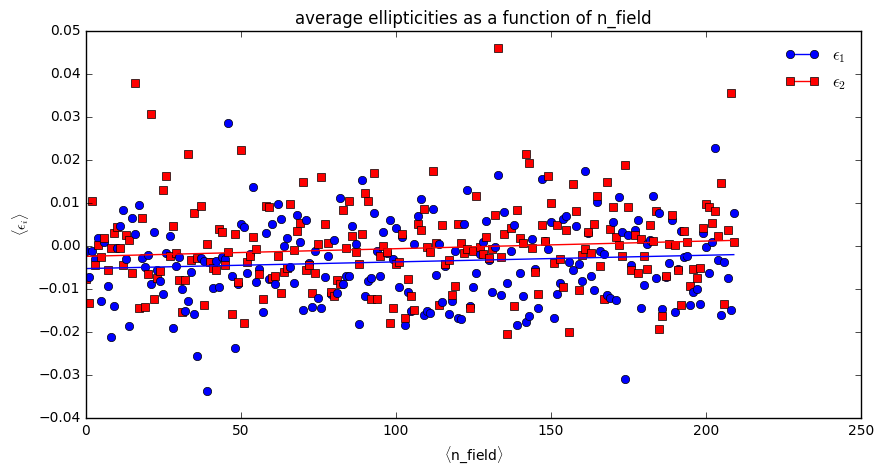

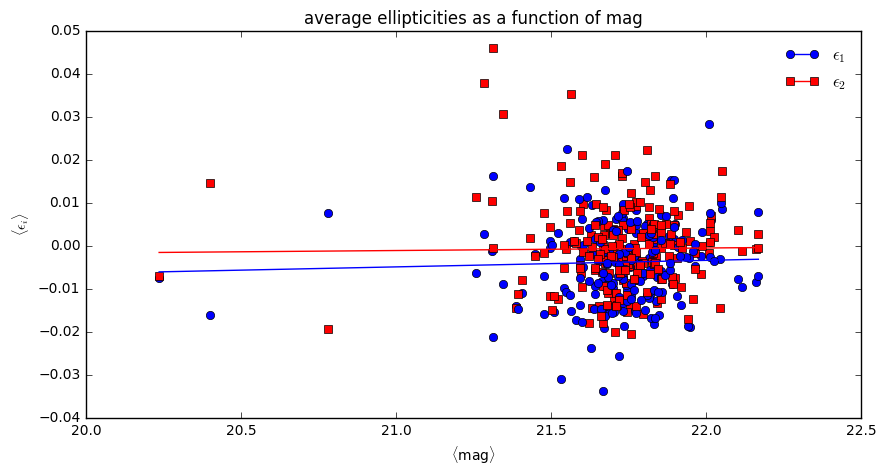

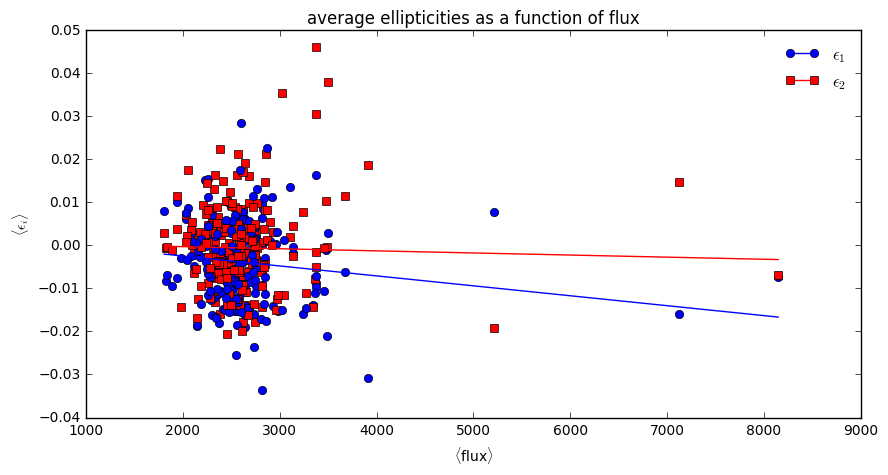

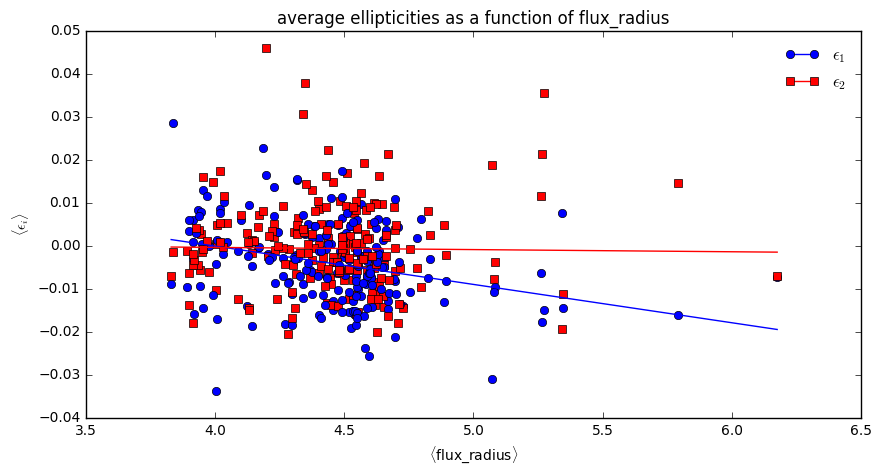

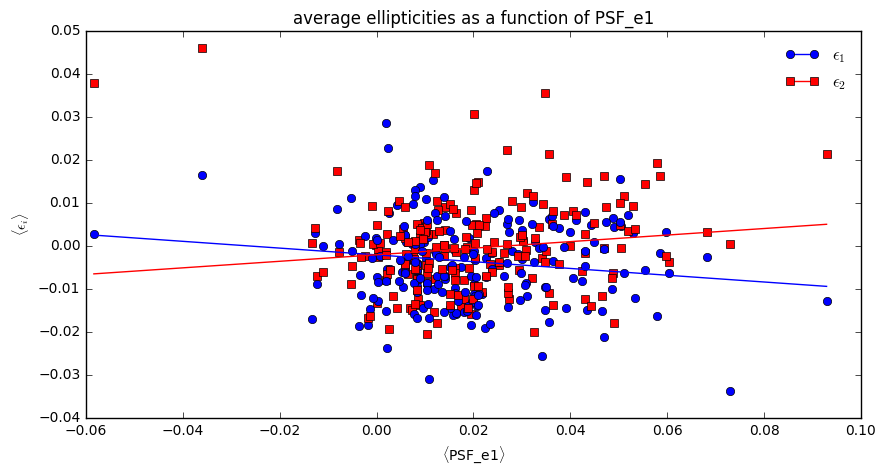

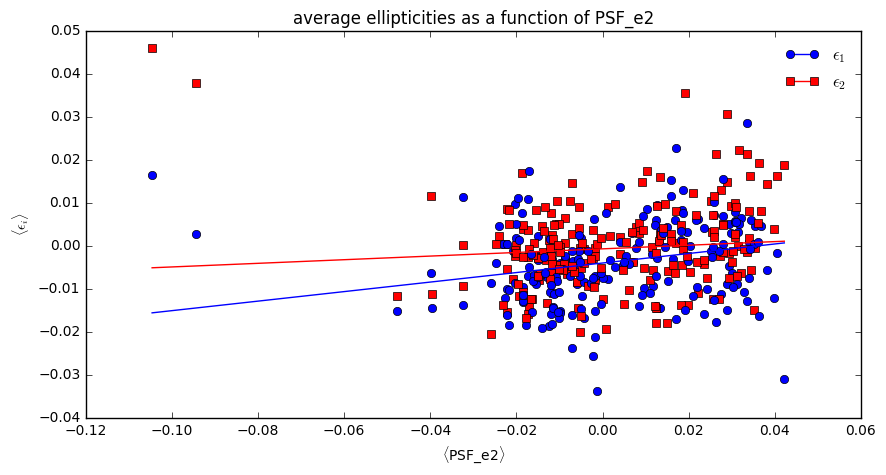

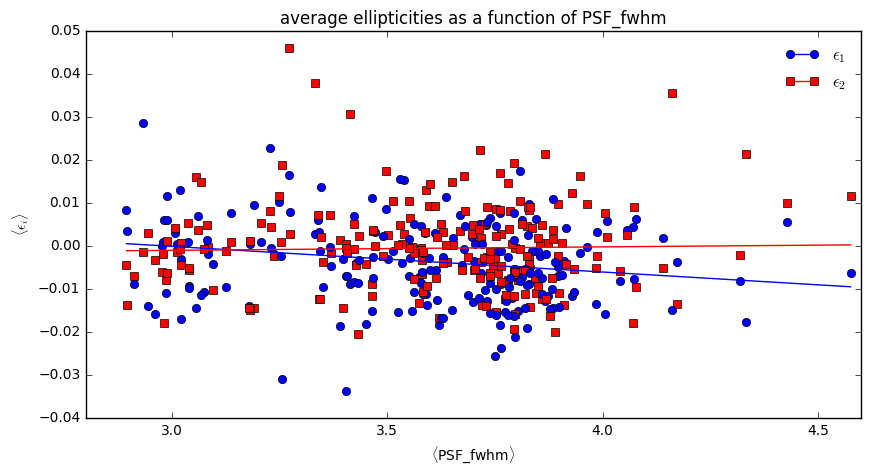

In [26]:
for name in ['n_field', 'mag', 'flux', 'flux_radius', 'PSF_e1', 'PSF_e2', 'PSF_fwhm']:
    plt.figure(figsize=[10,5])
    for i in np.unique(data['n_field']):
        plt.plot(np.mean(data[name][data['n_field'] == i]), np.mean(data['g1_median'][data['n_field'] == i]), marker = 'o', c = 'b', label = r'$\epsilon_{1}$')
        plt.plot(np.mean(data[name][data['n_field'] == i]), np.mean(data['g2_median'][data['n_field'] == i]), marker = 's', c = 'r', label = r'$\epsilon_{2}$')
    xvals = [np.mean(data[name][data['n_field'] == i]) for i in np.unique(data['n_field'])]
    b, a = np.polyfit(data[name], data['g1_median'], 1)
    plt.plot([min(xvals), max(xvals)], [a + b*min(xvals), a + b*max(xvals)], c = 'b')
    b, a = np.polyfit(data[name], data['g2_median'], 1)
    plt.plot([min(xvals), max(xvals)], [a + b*min(xvals), a + b*max(xvals)], c = 'r')
    plt.title('average ellipticities as a function of ' + name)
    plt.ylabel(r'$\langle \epsilon_i \rangle$')
    plt.xlabel(r'$\langle $'+name+'$ \\rangle$')
    plt.legend([r'$\epsilon_{1}$', r'$\epsilon_{2}$'], loc = 1, frameon = False)
    plt.show()

Here I show the same as before, but using the average Metacalibration responses in the y axis instead of the ellipticities.  

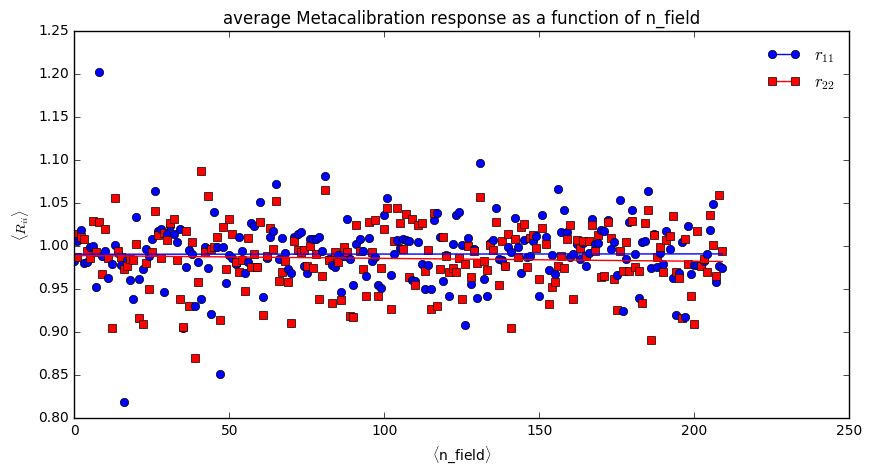

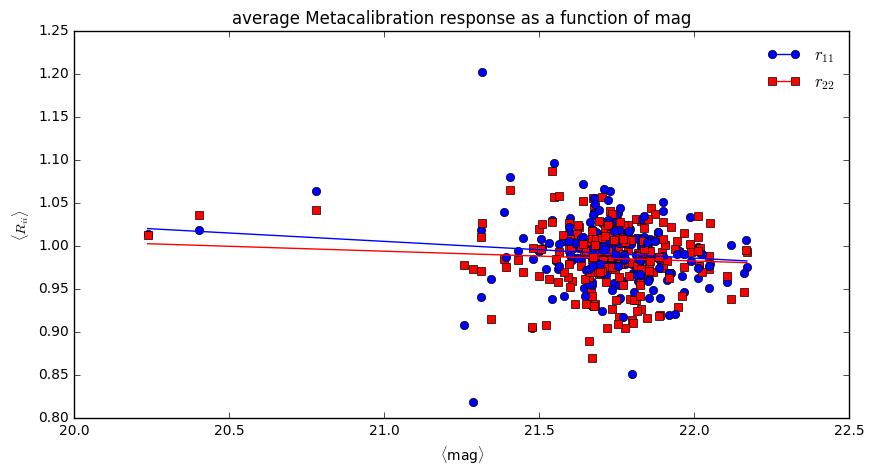

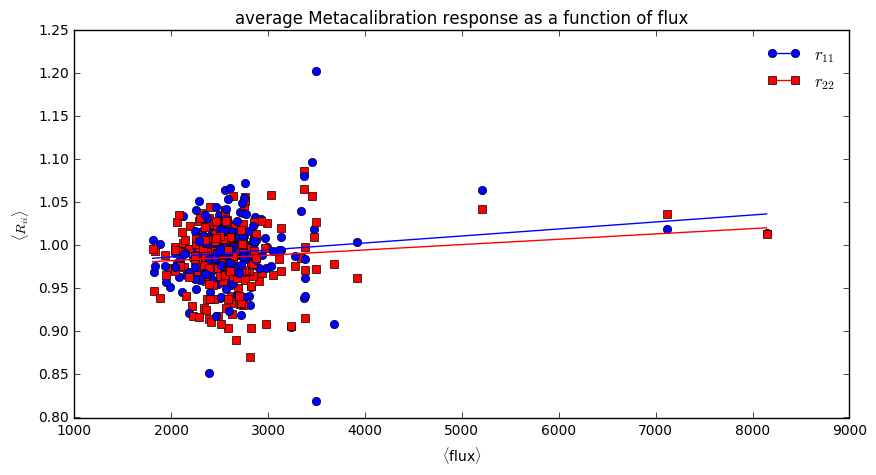

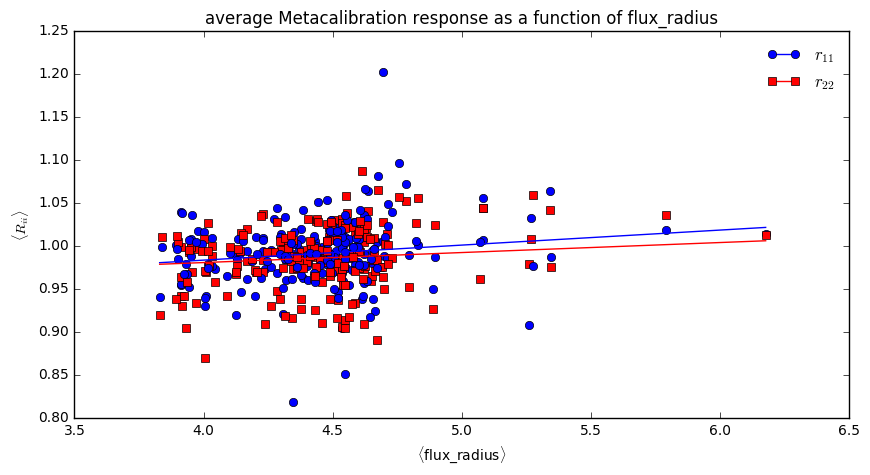

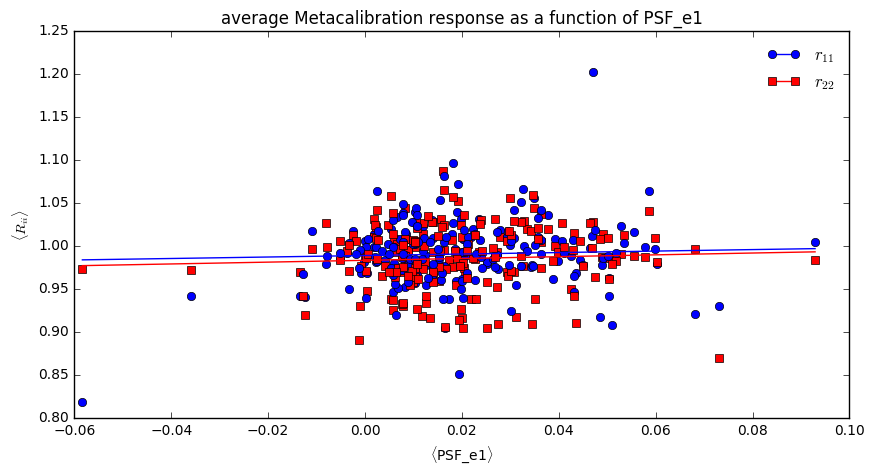

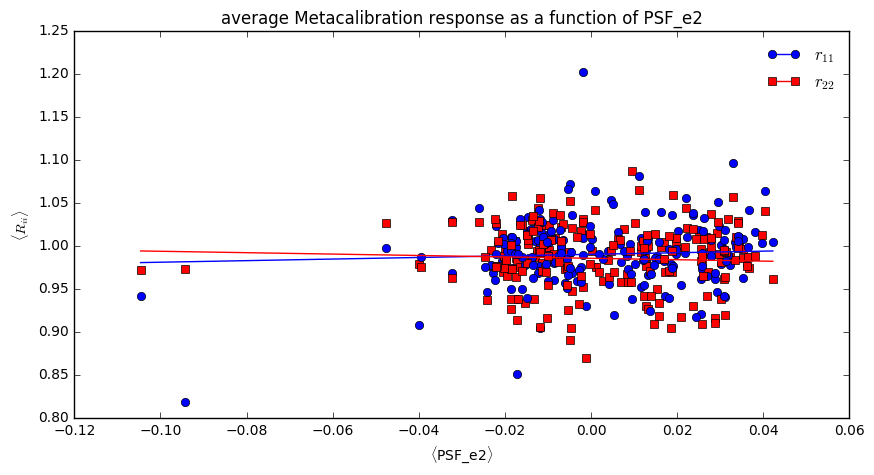

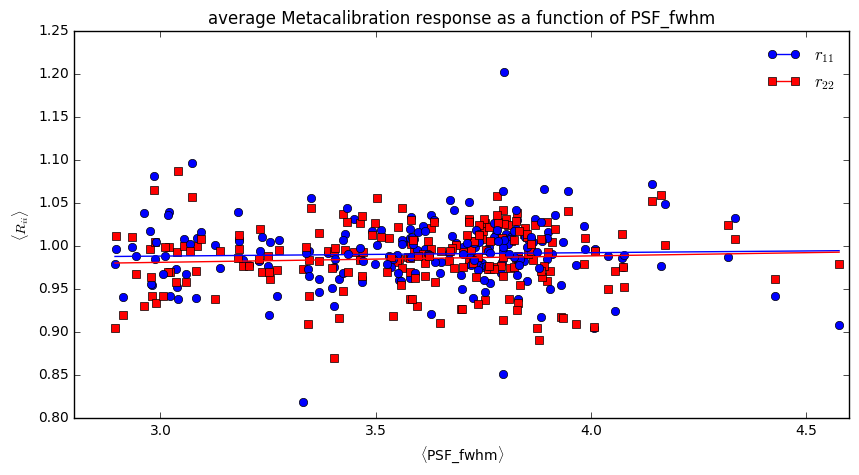

In [27]:
for name in ['n_field', 'mag', 'flux', 'flux_radius', 'PSF_e1', 'PSF_e2', 'PSF_fwhm']:
    plt.figure(figsize=[10,5])
    for i in np.unique(data['n_field']):
        plt.plot(np.mean(data[name][data['n_field'] == i]), np.mean(data['r11'][data['n_field'] == i]), marker = 'o', c = 'b', label = r'$r_{11}$')
        plt.plot(np.mean(data[name][data['n_field'] == i]), np.mean(data['r22'][data['n_field'] == i]), marker = 's', c = 'r', label = r'$r_{22}$')
    xvals = [np.mean(data[name][data['n_field'] == i]) for i in np.unique(data['n_field'])]
    b, a = np.polyfit(data[name], data['r11'], 1)
    plt.plot([min(xvals), max(xvals)], [a + b*min(xvals), a + b*max(xvals)], c = 'b')
    b, a = np.polyfit(data[name], data['r22'], 1)
    plt.plot([min(xvals), max(xvals)], [a + b*min(xvals), a + b*max(xvals)], c = 'r')
    plt.title('average Metacalibration response as a function of ' + name)
    plt.ylabel(r'$\langle R_{ii} \rangle$')
    plt.xlabel(r'$\langle $'+name+'$ \\rangle$')
    plt.legend([r'$r_{11}$', r'$r_{22}$'], loc = 1, frameon = False)
    plt.show()

# Cross correlations
Here I plot $\langle ab\rangle/\sqrt{\langle a^2\rangle\langle b^2\rangle}$, where $a$ is one map (specified in the title of the plots) and $b$ is another map (specified in the x-axis). This gives values between -1 (negative for anticorrelated maps) and 1 (positive for correlated maps). I calculate the correlations between all the maps, each plot focuses on one map and all its correlations. The values of these correlations are printed before the plot.

Cross-corr(num_counts,ellip1) = -0.0139601110305 +/- 0.00359137459324
Cross-corr(num_counts,ellip2) = -0.00211027066664 +/- 0.00260647310031
Cross-corr(num_counts,kappa_E) = -0.000559316930192 +/- 0.00354382985246
Cross-corr(num_counts,kappa_B) = -0.000695844394365 +/- 0.0030369331016
Cross-corr(num_counts,r11_map) = 0.655584714725 +/- 0.015137098285
Cross-corr(num_counts,r22_map) = 0.670972143781 +/- 0.0117804923314
Cross-corr(num_counts,psf_e1) = 0.569475822739 +/- 0.0297495191129
Cross-corr(num_counts,psf_e2) = 0.118601983515 +/- 0.140014531017
Cross-corr(num_counts,psf_fwhm) = 0.854406651884 +/- 0.00227986817555


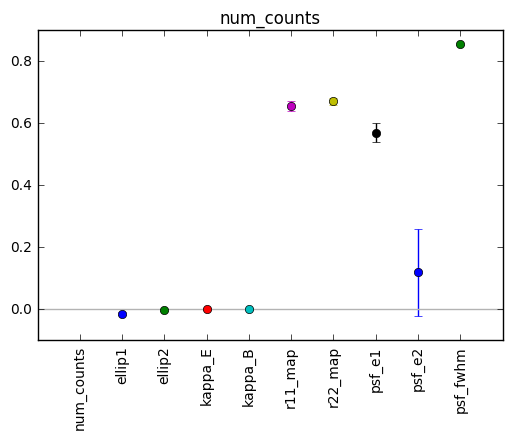

Cross-corr(ellip1,num_counts) = -0.0139601110305 +/- 0.00359137459324
Cross-corr(ellip1,ellip2) = 0.00318721264427 +/- 0.00454255907653
Cross-corr(ellip1,kappa_E) = -0.00263266463841 +/- 0.00242368749512
Cross-corr(ellip1,kappa_B) = 0.00557141698505 +/- 0.00322634137397
Cross-corr(ellip1,r11_map) = -0.00893648805915 +/- 0.00626472541258
Cross-corr(ellip1,r22_map) = -0.0170255056744 +/- 0.00438450602772
Cross-corr(ellip1,psf_e1) = -0.0175487908511 +/- 0.00377372969901
Cross-corr(ellip1,psf_e2) = 0.00856961388777 +/- 0.00317778259443
Cross-corr(ellip1,psf_fwhm) = -0.0162160174575 +/- 0.00449186736146


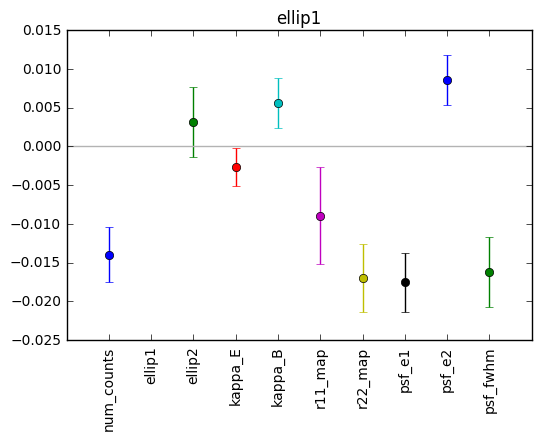

Cross-corr(ellip2,num_counts) = -0.00211027066664 +/- 0.00260647310031
Cross-corr(ellip2,ellip1) = 0.00318721264427 +/- 0.00454255907653
Cross-corr(ellip2,kappa_E) = -0.00134032938332 +/- 0.00377084093309
Cross-corr(ellip2,kappa_B) = -0.00406210274404 +/- 0.00364611896505
Cross-corr(ellip2,r11_map) = -0.0047707061177 +/- 0.00343108082072
Cross-corr(ellip2,r22_map) = -0.00576966509474 +/- 0.00315526536556
Cross-corr(ellip2,psf_e1) = 0.00366561847707 +/- 0.00391329925294
Cross-corr(ellip2,psf_e2) = 0.00344902020978 +/- 0.00310334863195
Cross-corr(ellip2,psf_fwhm) = -0.00228358346118 +/- 0.00346165081549


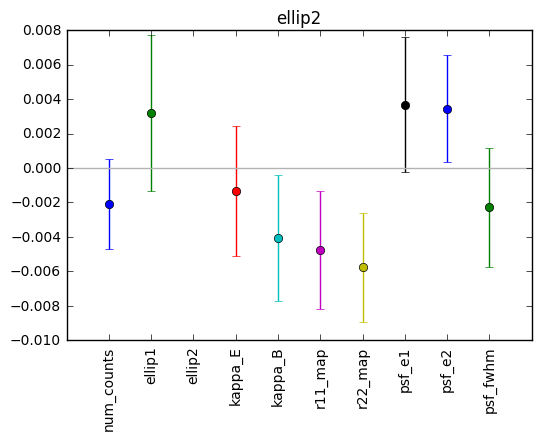

Cross-corr(kappa_E,num_counts) = -0.000559316930192 +/- 0.00354382985246
Cross-corr(kappa_E,ellip1) = -0.00263266463841 +/- 0.00242368749512
Cross-corr(kappa_E,ellip2) = -0.00134032938332 +/- 0.00377084093309
Cross-corr(kappa_E,kappa_B) = 0.000249227063588 +/- 0.00323045321612
Cross-corr(kappa_E,r11_map) = 0.00106852792286 +/- 0.00286333629568
Cross-corr(kappa_E,r22_map) = -0.00135876615021 +/- 0.00310293378654
Cross-corr(kappa_E,psf_e1) = -0.00622763516464 +/- 0.00230786614447
Cross-corr(kappa_E,psf_e2) = -0.0080982171721 +/- 0.00296584245832
Cross-corr(kappa_E,psf_fwhm) = 6.05406854618e-05 +/- 0.00325502358859


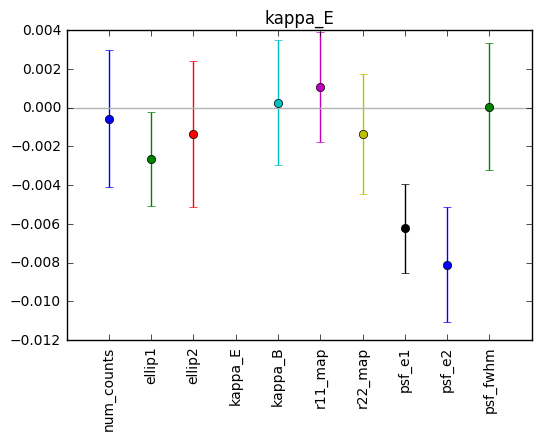

Cross-corr(kappa_B,num_counts) = -0.000695844394365 +/- 0.0030369331016
Cross-corr(kappa_B,ellip1) = 0.00557141698505 +/- 0.00322634137397
Cross-corr(kappa_B,ellip2) = -0.00406210274404 +/- 0.00364611896505
Cross-corr(kappa_B,kappa_E) = 0.000249227063588 +/- 0.00323045321612
Cross-corr(kappa_B,r11_map) = -0.000689960984211 +/- 0.00310090171542
Cross-corr(kappa_B,r22_map) = 0.00296211988954 +/- 0.0034819175025
Cross-corr(kappa_B,psf_e1) = -0.000686959540571 +/- 0.00279068697364
Cross-corr(kappa_B,psf_e2) = -0.00775329114513 +/- 0.0023509484256
Cross-corr(kappa_B,psf_fwhm) = 0.000620642381614 +/- 0.00282181845982


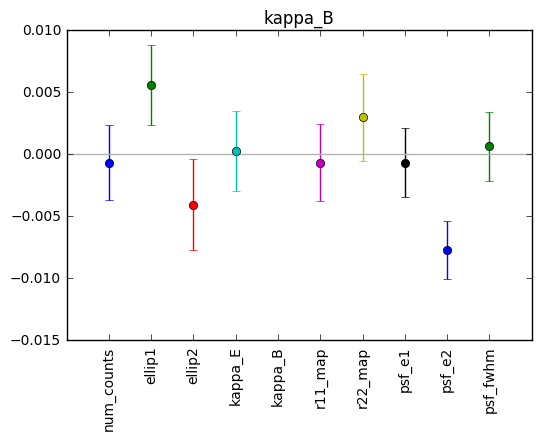

Cross-corr(r11_map,num_counts) = 0.655584714725 +/- 0.015137098285
Cross-corr(r11_map,ellip1) = -0.00893648805915 +/- 0.00626472541258
Cross-corr(r11_map,ellip2) = -0.0047707061177 +/- 0.00343108082072
Cross-corr(r11_map,kappa_E) = 0.00106852792286 +/- 0.00286333629568
Cross-corr(r11_map,kappa_B) = -0.000689960984211 +/- 0.00310090171542
Cross-corr(r11_map,r22_map) = 0.667869507654 +/- 0.0249005200156
Cross-corr(r11_map,psf_e1) = 0.50775397517 +/- 0.0212893898303
Cross-corr(r11_map,psf_e2) = 0.106851820095 +/- 0.118931453698
Cross-corr(r11_map,psf_fwhm) = 0.760054615807 +/- 0.0183673654138


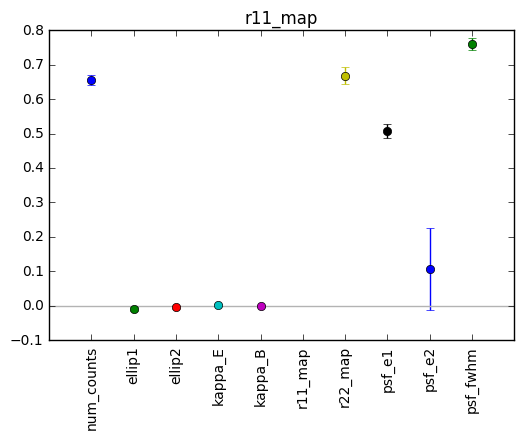

Cross-corr(r22_map,num_counts) = 0.670972143781 +/- 0.0117804923314
Cross-corr(r22_map,ellip1) = -0.0170255056744 +/- 0.00438450602772
Cross-corr(r22_map,ellip2) = -0.00576966509474 +/- 0.00315526536556
Cross-corr(r22_map,kappa_E) = -0.00135876615021 +/- 0.00310293378654
Cross-corr(r22_map,kappa_B) = 0.00296211988954 +/- 0.0034819175025
Cross-corr(r22_map,r11_map) = 0.667869507654 +/- 0.0249005200156
Cross-corr(r22_map,psf_e1) = 0.522163282019 +/- 0.0239443890291
Cross-corr(r22_map,psf_e2) = 0.108452358108 +/- 0.123199141468
Cross-corr(r22_map,psf_fwhm) = 0.779227275215 +/- 0.014142593323


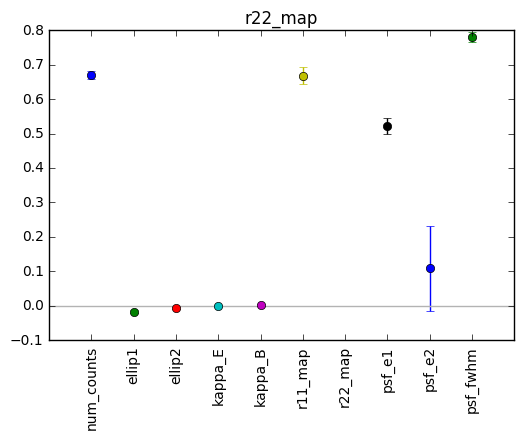

Cross-corr(psf_e1,num_counts) = 0.569475822739 +/- 0.0297495191129
Cross-corr(psf_e1,ellip1) = -0.0175487908511 +/- 0.00377372969901
Cross-corr(psf_e1,ellip2) = 0.00366561847707 +/- 0.00391329925294
Cross-corr(psf_e1,kappa_E) = -0.00622763516464 +/- 0.00230786614447
Cross-corr(psf_e1,kappa_B) = -0.000686959540571 +/- 0.00279068697364
Cross-corr(psf_e1,r11_map) = 0.50775397517 +/- 0.0212893898303
Cross-corr(psf_e1,r22_map) = 0.522163282019 +/- 0.0239443890291
Cross-corr(psf_e1,psf_e2) = 0.351068639475 +/- 0.11491426901
Cross-corr(psf_e1,psf_fwhm) = 0.673648272839 +/- 0.0321938503124


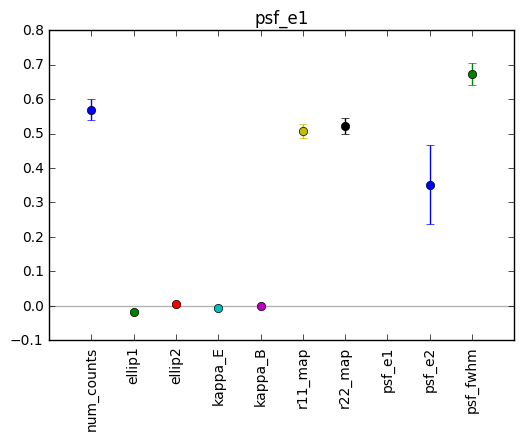

Cross-corr(psf_e2,num_counts) = 0.118601983515 +/- 0.140014531017
Cross-corr(psf_e2,ellip1) = 0.00856961388777 +/- 0.00317778259443
Cross-corr(psf_e2,ellip2) = 0.00344902020978 +/- 0.00310334863195
Cross-corr(psf_e2,kappa_E) = -0.0080982171721 +/- 0.00296584245832
Cross-corr(psf_e2,kappa_B) = -0.00775329114513 +/- 0.0023509484256
Cross-corr(psf_e2,r11_map) = 0.106851820095 +/- 0.118931453698
Cross-corr(psf_e2,r22_map) = 0.108452358108 +/- 0.123199141468
Cross-corr(psf_e2,psf_e1) = 0.351068639475 +/- 0.11491426901
Cross-corr(psf_e2,psf_fwhm) = 0.118004068905 +/- 0.157534033996


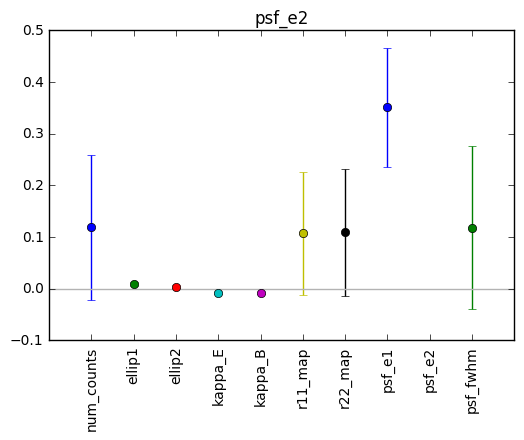

Cross-corr(psf_fwhm,num_counts) = 0.854406651884 +/- 0.00227986817555
Cross-corr(psf_fwhm,ellip1) = -0.0162160174575 +/- 0.00449186736146
Cross-corr(psf_fwhm,ellip2) = -0.00228358346118 +/- 0.00346165081549
Cross-corr(psf_fwhm,kappa_E) = 6.05406854618e-05 +/- 0.00325502358859
Cross-corr(psf_fwhm,kappa_B) = 0.000620642381614 +/- 0.00282181845982
Cross-corr(psf_fwhm,r11_map) = 0.760054615807 +/- 0.0183673654138
Cross-corr(psf_fwhm,r22_map) = 0.779227275215 +/- 0.014142593323
Cross-corr(psf_fwhm,psf_e1) = 0.673648272839 +/- 0.0321938503124
Cross-corr(psf_fwhm,psf_e2) = 0.118004068905 +/- 0.157534033996


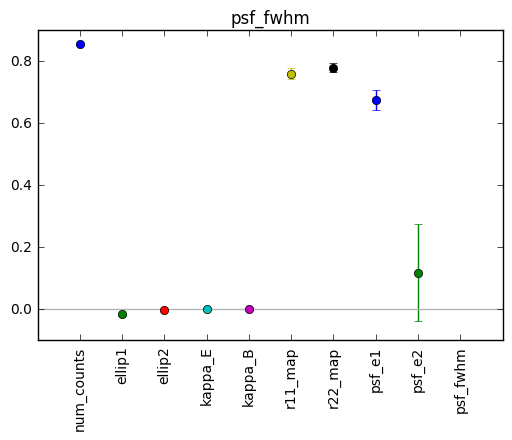

In [28]:
var_list = [num_counts, ellip1, ellip2, kappa_E, kappa_B, r11_map, r22_map, psf_e1, psf_e2, psf_fwhm]
var_names = ['num_counts', 'num_counts', 'ellip1', 'ellip1', 'ellip2', 'ellip2', 'kappa_E', 'kappa_E', 'kappa_B', 'kappa_B', 'r11_map', 'r11_map', 'r22_map', 'r22_map']
var_names = ['num_counts', 'ellip1', 'ellip2', 'kappa_E', 'kappa_B', 'r11_map', 'r22_map', 'psf_e1', 'psf_e2', 'psf_fwhm']
var_lims = [[-.15,.15], [-.05,.05], [-.05,.05], [-.07,.05], [-.05,.05], [-.015,.015], [-.015,.015], [-.05,.05], [-.05,.05], [-.2,.2]]

for i in range(len(var_list)):
    plt.figure(i)
    var_a = var_list[i]
    for j in range(len(var_list)):
        if i!= j:
            var_b = var_list[j]
            Xcorr, Xcorr_err = cross_corr(var_a[mask], var_b[mask], params['jk'], None)
            plt.errorbar(j, Xcorr, Xcorr_err, marker = 'o')
            print "Cross-corr("+var_names[i]+ ","+ var_names[j]+ ") = "+str(Xcorr) + " +/- "+ str(Xcorr_err)
    plt.title(var_names[i])
    plt.xticks(np.arange(len(var_names)), var_names, rotation='vertical')
    #plt.ylim(var_lims[i])
    plt.xlim(-1, len(var_names))
    plt.hlines(0,-1,len(var_names), colors=[.7,.7,.7])
    plt.show()

Observations:
- Strong correlation between number counts and PSF size (and PSF e1). It seems there high quality regions where we detect a) more objects with b) smaller PSFs. This could also be the cause for the correlation with the Metacal responses.
- anticorrelation between e1 and PSF_e1, and correlation between e1 and PSF_e2. It might come from not good enough calibration, or not too precise PSF estimation. e1 is also anticorrelated with the PSF size, so e1 might depend on the data quality. 
- e1 and e2 correlated. This might come from an uncorrected bias. This can depend on the calibration scheme as well. 
- kappa_B anticorrelated with PSF_e2
- Metacal responses are correlated with number counts, PSF_e1 and PSF size. 
- PSF size is correlated with e1 but not with e2. Any possible reason for this?

I am not sure about how significant they are, given the amount of data, area, etc. 

# Smoothed maps

# If you have astropy 

In [29]:
from astropy.convolution import convolve_fft, convolve, Tophat2DKernel

In [30]:
def get_ang_smoothing(params):
    """
    it translates the smoothing scale to number of pixels.
    """
    smooth = max(1,int(round(params['smooth']/params['pix'], 0)))
    print "smoothing pixel: ", smooth
    return smooth

In [31]:
params['smooth_mode'] = 'tophat' #can be also 'boxcar'

smoothing pixel:  10


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/astropy/convolution/convolve.py:588: RuntimeWarning: divide by zero encountered in true_divide
  rifft = (ifftn(fftmult)) / bigimwt
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/astropy/convolution/convolve.py:588: RuntimeWarning: invalid value encountered in true_divide
  rifft = (ifftn(fftmult)) / bigimwt


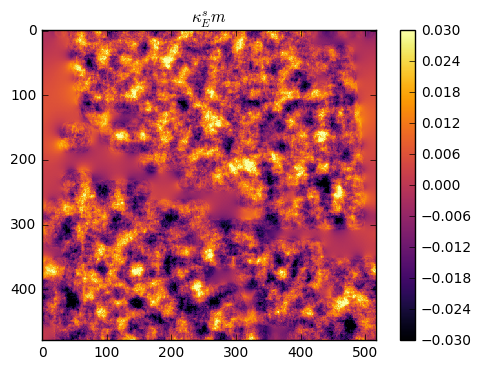

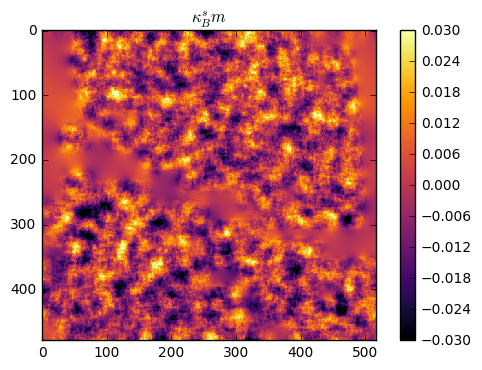

In [32]:
smooth_s = get_ang_smoothing(params)
if params['smooth_mode'] == 'boxcar':
    smooth_kernel = np.ones((smooth_s, smooth_s))
elif params['smooth_mode'] == 'tophat':
    smooth_kernel = Tophat2DKernel(smooth_s)
else:
    print "ERROR: Unknown smooth kernel"
kappa_E_sm = convolve_fft(kappa_E, smooth_kernel, normalize_kernel = np.sum, interpolate_nan = True, ignore_edge_zeros = True) 
kappa_B_sm = convolve_fft(kappa_B, smooth_kernel, normalize_kernel = np.sum, interpolate_nan = True, ignore_edge_zeros = True)

plt.imshow(kappa_E_sm[::-1,::-1], interpolation='none', cmap = 'inferno', vmin = -.03, vmax = .03)
plt.title(r'$\kappa_E^sm$')
plt.colorbar()
plt.show()

plt.imshow(kappa_B_sm[::-1,::-1], interpolation='none', cmap = 'inferno', vmin = -.03, vmax = .03)
plt.title(r'$\kappa_B^sm$')
plt.colorbar()
plt.show()